### Описание датасета
-  Регион - субъект Российской Федерации, где находится медицинское учреждение
-  Календарный_год - год
-  Период - месяц
-  gender - пол респондента
-  poselenie - ответ на вопрос "Вы постоянно проживаете в городе или в сельской местности?"
-  Населенный_пункт - название населенного пункта, где находится медицинское учреждение
-  org_type - ответ на вопрос "В каких организациях Вы обычно получаете медицинскую помощь?"
-  last_visit - ответ на вопрос "Как давно Вы в последний раз получали медицинскую помощь?"
-  time_of_register - ответ на вопрос "Насколько Вы согласны с утверждением, что сейчас Вы можете записаться к врачу в удобное для Вас время?" (1-5 баллы по 5-бальной шкале)
-  wait_time - ответ на вопрос "Насколько Вы удовлетворены длительностью ожидания медицинской услуги с момента возникновения потребности в медицинской помощи до момента ее получения?" (1-5 баллы по 5-бальной шкале)
-  near_cab - ответ на вопрос "Насколько Вы удовлетворены длительностью ожидания непосредственно перед кабинетом?" (1-5 баллы по 5-бальной шкале)
-  comfort - ответ на вопрос "Насколько комфортным было Ваше пребывание в медицинской организации (комфортность зон ожидания, комфортное перемещение внутри медицинской организации)?" (1-5 баллы по 5-бальной шкале)
-  attitude - ответ на вопрос "Насколько Вы удовлетворены отношением к Вам со стороны медицинского персонала (врачи, мед. сестры, регистраторы, санитары)?" (1-5 баллы по 5-бальной шкале)
-  explain - ответ на вопрос "Удовлетворены ли Вы тем, как врач объяснял Вам, зачем назначено то или иное лечение, лекарственный препарат, диагностическая процедура?" (1-5 баллы по 5-бальной шкале)
-  expect - ответ на вопрос "Насколько результат Вашего обращения в медицинскую организацию соответствовал Вашим ожиданиям?" (1-5 баллы по 5-бальной шкале)
-  loyalty - ответ на вопрос "Вы бы посоветовали близким друзьям или родственникам обращаться за медицинской помощью в Вашу медицинскую организацию?" (1-5 баллы по 5-бальной шкале)
-  gen_sat - ответ на вопрос "Оцените, насколько в целом Вы удовлетворены медицинской помощью?" (1-5 баллы по 5-бальной шкале)
-  open_question_1 - ответ на вопрос "Что Вы можете назвать наибольшей проблемой в процессе получения медицинской помощи в медицинской организации, в которой Вы получаете медицинскую помощь?"
-  open_question_2 - ответ на вопрос "Что Вы можете назвать наибольшей проблемой в процессе получения медицинской помощи в регионе, в котором Вы проживаете?"
-  date_of_survey - дата опроса
-  respondent_number - номер респондента
-  doctor_domestic_visit_problem - ответ на вопрос "Возникали ли у Вас сложности при вызове врача на дом?"
-  diag_services_available - ответ на вопрос "Можете ли Вы получить при оказании первичной медико-санитарной помощи в Вашей медицинской организации диагностические и лабораторные услуги?"
-  disabled_facilitites_available - ответ на вопрос "Есть ли в Вашей медицинской организации приспособления для лиц с ограниченными возможностями?
-  problem_solved - ответ на вопрос "Была ли решена Ваша медицинская проблема?"
- region_medical_care - ответ на вопрос "Оцените, насколько Вы удовлетворены доступностью медицинской помощи в Вашем регионе?"

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_curve, auc, precision_recall_curve, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
from imblearn.over_sampling import SMOTE
import mlflow
import mlflow.sklearn
import os
from scipy.special import softmax
from scipy.stats import chi2_contingency
from datetime import datetime
import time
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

In [ ]:
from tqdm import tqdm
tqdm.pandas()
from clearml import Task, Logger, StorageManager, Dataset
import joblib
from boruta import BorutaPy
import shap
from sklearn.tree import plot_tree

In [ ]:
df = pd.read_csv('Anketa.csv', on_bad_lines='warn', sep=';')
df.shape

In [ ]:
df.head()

In [ ]:
# Переименуем колонки
column_mapping = {
    'Календарный_год': 'year',
    'Регион': 'Region',
    'Период': 'period',
    'poselenie': 'locality_type',
    'Населенный_пункт': 'locality',
    'zapis': 'time_of_register',
    'ozhid': 'wait_time',
    'Дата_проведения_опроса_в_формате_дд_мм_гггг': 'date_of_survey',
    'Номер_респондента': 'respondent_number',
    '16': 'region_medical_care_availability',
    '17': 'doctor_domestic_visit_problem',
    '18': 'diag_services_available',
    '19': 'disabled_facilitites_available',
    'Возраст': 'age'
}

df = df.rename(columns=column_mapping)
columns_to_remove = ['Id', 'Удовлетворенность_доступностью_лекарств', 'health_selfestimation', 'children_number', '1st_child_health', '2nd_child_health', '3d_child_health', '4th_child_health', '5th_child_health']
df = df.drop(columns=columns_to_remove, errors='ignore')
df.head()

#### EDA

##### Разберемся, что делать с вариантами Затрудняюсь ответить

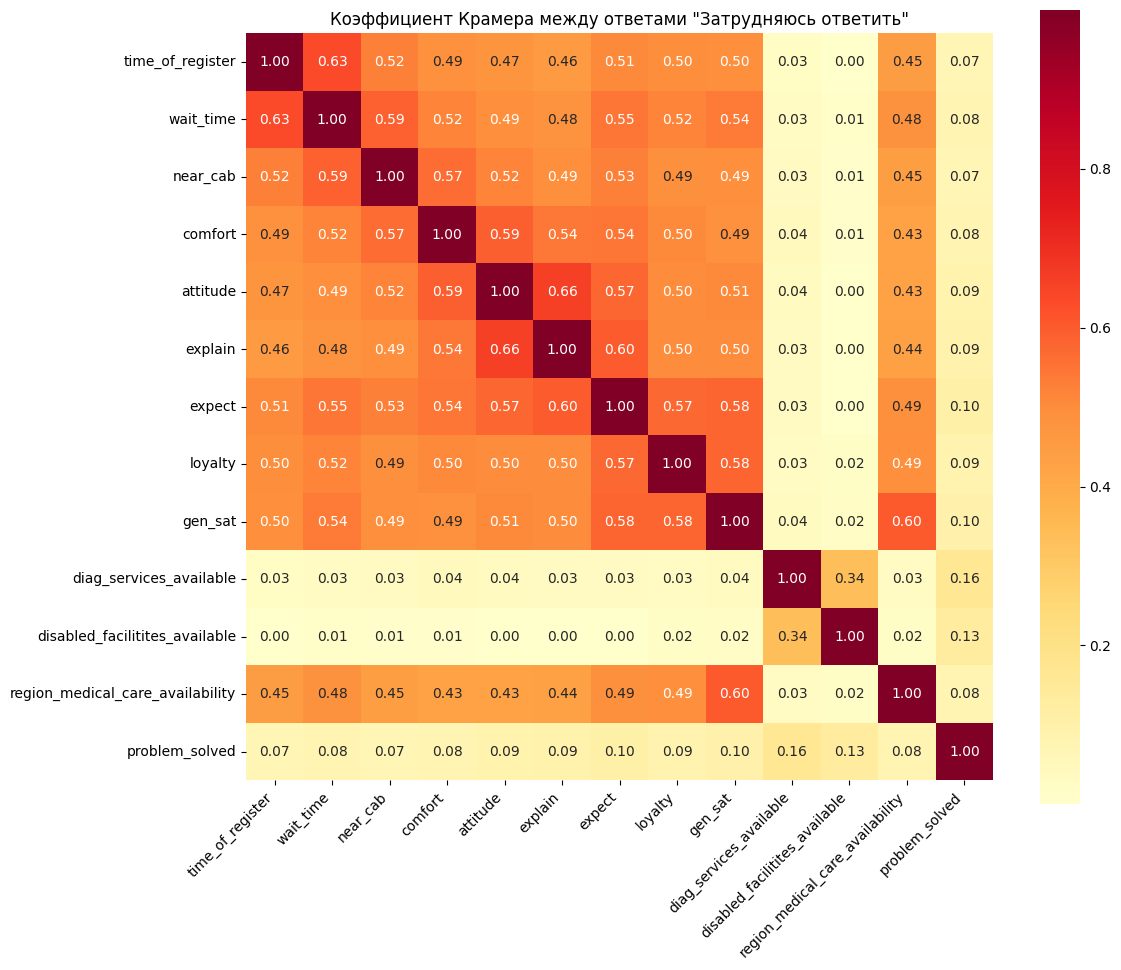

In [ ]:
# Список колонок для анализа
columns = [
    'time_of_register', 'wait_time', 'near_cab', 'comfort',
    'attitude', 'explain', 'expect', 'loyalty', 'gen_sat',
    'diag_services_available', 'disabled_facilitites_available',
    'region_medical_care_availability', 'problem_solved'
]

# Создаем матрицы для хранения результатов
association_matrix = pd.DataFrame(index=columns, columns=columns)
cramer_matrix = pd.DataFrame(index=columns, columns=columns)

# Функция для вычисления коэффициента Крамера
def cramers_v(contingency_matrix):
    try:
        chi2 = chi2_contingency(contingency_matrix)[0]
        n = contingency_matrix.sum().sum()
        min_dim = min(contingency_matrix.shape) - 1
        return np.sqrt(chi2 / (n * min_dim)) if n * min_dim > 0 else 0.0
    except:
        return 0.0
# Создаем все комбинации колонок
combinations = [(col1, col2) for col1 in columns for col2 in columns]
# Заполняем матрицы
for col1, col2 in tqdm(combinations, 
                       desc="Вычисление коэффициентов Крамера", 
                       total=len(combinations),
                       unit="пара"):
    # Создаем таблицу сопряженности для "Затрудняюсь ответить"
    mask1 = df[col1] == 'Затрудняюсь ответить'
    mask2 = df[col2] == 'Затрудняюсь ответить'
    contingency = pd.crosstab(mask1, mask2)
        
    # Вычисляем коэффициент Крамера
    cramer_v = cramers_v(contingency)
    cramer_matrix.loc[col1, col2] = cramer_v

# Создаем тепловую карту для коэффициента Крамера
plt.figure(figsize=(12, 10))
sns.heatmap(cramer_matrix.astype(float), 
            annot=True, 
            cmap='YlOrRd', 
            fmt='.2f',
            square=True)
plt.title('Коэффициент Крамера между ответами "Затрудняюсь ответить"')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

##### Видно, что problem_solved не зависит от других ответов

In [ ]:
# Предположим, что строки с вариантом "Затрудняюсь ответить" можно удалить

# Создаем маску для каждого столбца
masks = {col: df[col] == 'Затрудняюсь ответить' for col in columns}

# Создаем DataFrame с масками
mask_df = pd.DataFrame(masks)

# Подсчитываем количество совпадений для каждой строки
mask_df['count'] = mask_df.sum(axis=1)

# Группируем по количеству совпадений и подсчитываем частоту
coincidence_counts = mask_df['count'].value_counts().sort_index()
coincidence_counts.index = range(1, len(coincidence_counts) + 1)
plt.figure(figsize=(12, 6))
ax = coincidence_counts.plot(kind='bar')
plt.title('Распределение количества совпадений варианта "Затрудняюсь ответить"')
plt.xlabel('Количество совпадений')
plt.ylabel('Количество строк')
plt.grid(True, axis='y')
for i, v in enumerate(coincidence_counts):
    ax.text(i, v, str(v), ha='center', va='bottom')
plt.show()

In [ ]:
# Удаляем строки, где количество совпадений варианта "Затрудняюсь ответить" равно 10 или 11
rows_to_drop = mask_df[mask_df['count'].isin([10, 11, 12, 13])].index
df = df.drop(rows_to_drop)
print(df.shape)

##### Сгенерим новые фичи на основе вариантов Затрудняюсь ответить на этапе генерации фич


In [ ]:
# Целевой признак: problem_solved
plt.figure(figsize=(6, 4))
sns.countplot(x='problem_solved', data=df)
plt.title('Распределение целевого признака: problem_solved')
plt.show()
# TODO сделать 3 класса

In [ ]:
# имбаланс исправим на этапе разделдения выборок

In [ ]:
# Целевой признак: Age
# Строим распределение возраста
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='age', bins=50, kde=True)
plt.title('Распределение возраста респондентов')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.grid(True)
plt.show()

# Выводим базовую статистику
print("\nСтатистика по возрасту:")
print(df['age'].describe())


In [ ]:
# Удалим строки с возрастом меньше 18 и аномальными значениями сверху
# Создаем box plot для анализа выбросов
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, y='age', hue='gender', palette='Set2')
plt.title('Диаграмма выбросов возраста респондентов')
plt.ylabel('Возраст')
plt.grid(True, axis='y')

In [ ]:
#вывести строки с id 781887
# df.loc[781788 : 781788 + 99]
# 781832
# df[df['age'] > 100]

In [ ]:
# сначала удалим невалидные значения
df = df[df['age'] >= 18]
df = df[df['age'] <= 100]
df = df.drop(index=range(781832, 781832 + 52))

In [ ]:
# Расчёт квартилей и IQR
Q1 = df['age'].quantile(0.25)
Q3 = df['age'].quantile(0.75)
IQR = Q3 - Q1

In [ ]:
# Верхняя граница
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR

# Удаление выбросов сверху
df = df[df['age'] <= upper_bound]
# Удалим строки с возрастом меньше 18
df = df[df['age'] >= lower_bound]

In [ ]:
df.shape

In [ ]:
# Пропуски
display(df.isnull().sum())

In [ ]:
# Посмотрим пропуски в target
period_mapping = {
    'Январь': 1,
    'Февраль': 2,
    'Март': 3,
    'Апрель': 4,
    'Май': 5,
    'Июнь': 6,
    'Июль': 7,
    'Август': 8,
    'Сентябрь': 9,
    'Октябрь': 10,
    'Ноябрь': 11,
    'Декабрь': 12
}

# Применяем маппинг к столбцу 'period'
df['period'] = df['period'].map(period_mapping)

# Группируем данные
grouped_total = df.groupby(['year', 'period'])['problem_solved'].count().rename('total_count')
grouped_missing = df.groupby(['year', 'period'])['problem_solved'].apply(lambda x: x.isnull().sum()).rename('missing_count')

result = pd.concat([grouped_total, grouped_missing], axis=1).reset_index()

result['Year_Month'] = result['year'].astype(str) + '-' + result['period'].astype(str)

# Строим график
plt.figure(figsize=(14, 7))
sns.lineplot(data=result, x='Year_Month', y='total_count', label='Общее количество', marker='o')
sns.lineplot(data=result, x='Year_Month', y='missing_count', label='Пропущенные значения', marker='x')

plt.xticks(rotation=45)
plt.title('Количество записей и пропусков в problem_solved по месяцам и годам')
plt.xlabel('Год-Месяц')
plt.ylabel('Количество')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

# Удаляем ненужные колонки
# df = df.drop(columns=['respondent_number'])
# TODO посмотреть почему много пропусков
# TODO посмотреть есть ли комментарий

In [ ]:
# Проверим, может дело в Регионе
# Группировка с учётом региона
grouped_total = df.groupby(['year', 'period', 'Region'])['problem_solved'].count().rename('total_count')
grouped_missing = df.groupby(['year', 'period', 'Region'])['problem_solved'].apply(lambda x: x.isnull().sum()).rename('missing_count')

# Объединение результатов
result = pd.concat([grouped_total, grouped_missing], axis=1).reset_index()
result = result.sort_values(by=['missing_count','year', 'period', 'Region'],
                            ascending=[False, True, True, True]).head(15)
display(result)


In [ ]:
# Посмотрим на пропуски более детально: м.б. строки пустые целиком (т.е. мусор), 
# либо респонденты не ответили на вопросы после того, как посатвили низкую оценку по одному из вопросов (1-2)
df_analysis = df.copy()
# Столбцы, которые НЕ являются оценочными/опросными
id_cols = ['Region', 'year', 'period', 'date_of_survey', 'respondent_number', 'locality', 'org_type']
# Опросные/оценочные столбцы (все, кроме id_cols)
survey_cols = [col for col in df_analysis.columns if col not in id_cols]
# Визуализация общего распределения пропусков ---
plt.figure(figsize=(18, 10))
sns.heatmap(df_analysis[survey_cols].isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Тепловая карта пропущенных значений в опросных столбцах (желтый - пропуск)')
plt.show()

missing_counts = df_analysis[survey_cols].isnull().sum().sort_values(ascending=False)
missing_counts = missing_counts[missing_counts > 0] # Только столбцы с пропусками

plt.figure(figsize=(12, 8))
missing_counts.plot(kind='bar')
plt.title('Количество пропусков')
plt.ylabel('Количество пропусков')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
# Получаем топ-16 регионов по количеству пропусков
filtered_df = df[
    (df['period'] == 6) & 
    (df['year'] == 2023)
]
top_regions = filtered_df.groupby('Region')['problem_solved'].apply(lambda x: x.isna().sum()).sort_values(ascending=False).head(9).index
# Создаем фигуру с 16 subplots (4x4)
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
axes = axes.flatten()

# heatmaps
for idx, region in enumerate(top_regions):
    region_data = df[df['Region'] == region]
    missing_matrix = region_data[survey_cols].isnull()
    sns.heatmap(missing_matrix, 
                ax=axes[idx],
                cbar=False,
                cmap='viridis',
                yticklabels=False)
    
    axes[idx].set_title(f'{region}', fontsize=10)
    axes[idx].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

In [ ]:
# можно посмтотреть, какие признаки остутствуют вместе, что свидетельствует о полностью пустых строках
import missingno as msno
msno.heatmap(df[survey_cols])
plt.show()


In [ ]:
# можно удалить пустые строки
df = df.dropna(subset=['problem_solved'])
df.shape

In [ ]:
top_10_regions = df['Region'].value_counts().head(10).index
  
pivot_data = pd.pivot_table(
    df[
        (df['Region'].isin(top_10_regions)) & 
        (df['period'].isin([1, 2, 3, 4, 5, 6])) & 
        (df['year'] == 2024)
    ],
    values='gen_sat',
    index='Region',
    columns=['period','gender'],
    aggfunc=lambda x: round(((x == '4') | (x == '5')).mean() * 100, 1)
)
display(pivot_data.style
        .background_gradient(cmap='Blues', vmin=0, vmax=100)
        .format('{:.1f}%')
        )
# хи квадрат для связи между полом и оценкой
compare1 = pd.crosstab(df['gen_sat'], df['gender']) 
compare2 = pd.crosstab(df['comfort'], df['gender'])
compare3 = pd.crosstab(df['wait_time'], df['gender'])
df['age_group'] = pd.cut(df['age'], 
                        bins=[0, 30, 45, 60, 100],
                        labels=['18-30', '31-45', '46-60', '60+'])
compare4 = pd.crosstab(df['gen_sat'], df['age_group'])

chi2, p, dof, expected = chi2_contingency(compare1)  
print(f'Взаимосвязь между полом и оценкой: χ²: {chi2}, p-значение: {p}')  
chi2, p, dof, expected = chi2_contingency(compare2)  
print(f'Взаимосвязь между полом и удобством: χ²: {chi2}, p-значение: {p}') 
chi2, p, dof, expected = chi2_contingency(compare3)  
print(f'Взаимосвязь между полом и временем ожидания: χ²: {chi2}, p-значение: {p}') 
chi2, p, dof, expected = chi2_contingency(compare4)  
print(f'Взаимосвязь между возрастом и оценкой: χ²: {chi2}, p-значение: {p}') 

In [ ]:
# TODO проверить гипотезу от разной значимости признаков для женщин и мужчин, также для разных возрастов
# TODO могут быть подозрительные данные, когда ту же самую анекету залили в следующем периоде
# TODO доделать преобразование в координаты и создание карты
# TODO обработать текст open_question_1 и open_question_2
# TODO заджойнить с другими таблицами

### Feature Engineering

In [ ]:
# Перевернем таргет
mapping = {'Да': 0, 'Нет': 1, 'Затрудняюсь ответить': 1}
df['problem_not_solved'] = df['problem_solved'].map(mapping)
df.shape

In [ ]:
# создадим фичи на основе вариантов Затрудняюсь ответить
columns = [
    'time_of_register', 'wait_time', 'near_cab', 'comfort',
    'attitude', 'explain', 'expect', 'loyalty', 'gen_sat',
    'diag_services_available', 'disabled_facilitites_available',
    'region_medical_care_availability'
]

for col in columns:
    df[f'{col}_difficult'] = (df[col] == 'Затрудняюсь ответить').astype(int)
    mode_value = df[col].replace('Затрудняюсь ответить', np.nan).mode()[0]
    df[col] = df[col].replace('Затрудняюсь ответить', mode_value) 

In [ ]:

# Признаки удовлетворенности
satisfaction_columns = ['time_of_register', 'wait_time', 'near_cab', 'comfort',
                          'attitude', 'explain', 'expect', 'loyalty', 'gen_sat', 'region_medical_care_availability']
    

# Средняя удовлетворенность
value_map = {
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5
}
df_satisfaction = df[satisfaction_columns].replace(value_map)
df[satisfaction_columns] = df[satisfaction_columns].replace(value_map)
df['avg_satisfaction'] = df[satisfaction_columns].mean(axis=1)

# Стандартное отклонение удовлетворенности
df['satisfaction_std'] = df[satisfaction_columns].std(axis=1)
    
# Количество максимальных оценок
df['max_ratings_count'] = (df[satisfaction_columns] == 5).sum(axis=1)
    
# Количество минимальных оценок
df['min_ratings_count'] = (df[satisfaction_columns] == 1).sum(axis=1)

In [ ]:
# Преобразуем last_visit в числовые значения
visit_mapping = {
        'менее 1 мес. назад': 0.5,
        'от 1 до 3 мес. назад': 2,
        'от 3 до 4 мес. назад': 3.5,
        'от 4 до 6 мес. назад': 5,
        'от 6 до 12 мес. назад': 9,
        'более 12 мес. назад': 18
}
df['last_visit_months'] = df['last_visit'].map(visit_mapping)
df['visit_frequency'] = 1 / (df['last_visit_months'] + 0.1)
# Бинарные признаки
df['is_urban'] = df['locality_type'].map({'Город': 1, 'Село': 0})
df['is_male'] = (df['gender'] == 'Мужской').astype(int)
df = df.dropna(subset=['org_type'])
df['is_state_org'] = df['org_type'].str.contains('государственных').astype(int)
# Признаки доступности услуг
df['has_home_visit_problem'] = (df['doctor_domestic_visit_problem'] == 'Да').astype(int)
df['diag_available'] = (df['diag_services_available'] == 'Да').astype(int)
df['disabled_facilities'] = (df['disabled_facilitites_available'] == 'Да').astype(int)
# Общий индекс доступности
df['accessibility_index'] = (df['has_home_visit_problem'] + 
                               df['diag_available'] + 
                               df['disabled_facilities']) / 3
    
# Индекс качества обслуживания
df['service_quality_index'] = (df['time_of_register'] + 
                                 df['wait_time'] + 
                                 df['near_cab'] + 
                                 df['comfort']) / 4
    
# Индекс взаимодействия с персоналом
df['staff_interaction_index'] = (df['attitude'] + 
                                   df['explain'] + 
                                   df['expect']) / 3
# Количество респондентов в регионе
region_counts = df['Region'].value_counts()
df['region_respondent_count'] = df['Region'].map(region_counts)
    
# Средняя удовлетворенность по региону
region_satisfaction = df.groupby('Region')['avg_satisfaction'].mean()
df['region_avg_satisfaction'] = df['Region'].map(region_satisfaction)

# Средний возраст по региону
region_age = df.groupby('Region')['age'].mean()
df['region_avg_age'] = df['Region'].map(region_age)
    
# Label Encoding (числовое кодирование)
le = LabelEncoder()
df['region_label'] = le.fit_transform(df['Region'])
# TODO изучить one code encoder, бинарный (сколько колонок потребуется чтобы закодировать 153 уникальных значения), LabelEncoder (отличие от TargetEncoder), кэшированный признак

# target encoding для problem_solved по региону
region_target_encoding = df.groupby('Region')['problem_not_solved'].agg(['mean']).reset_index()
region_problem_mapping = region_target_encoding.set_index('Region')['mean'].to_dict()
df['region_target_encoding'] = df['Region'].map(region_problem_mapping)

# Полиномиальные признаки
numeric_features = [
        'age',
        'avg_satisfaction',
        'satisfaction_std',
        'last_visit_months',
        'visit_frequency',
        'service_quality_index',
        'staff_interaction_index',
        'accessibility_index',
        'region_avg_satisfaction',
        'region_avg_age'
]

# Заполняем пропуски в числовых признаках
for feature in numeric_features:
    if feature in df.columns:
        df[feature] = df[feature].fillna(df[feature].mean())

# Создаем полиномиальные признаки степени 2
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df[numeric_features])

feature_names = poly.get_feature_names_out(numeric_features)
poly_df = pd.DataFrame(poly_features, columns=feature_names)
poly_df = poly_df.drop(columns=numeric_features) 
   
# Добавляем полиномиальные признаки к основному DataFrame
df = pd.concat([df.reset_index(drop=True), poly_df.reset_index(drop=True)], axis=1)
    
# Создаем признаки взаимодействия между удовлетворенностью и демографическими характеристиками
df['satisfaction_age_interaction'] = df['avg_satisfaction'] * df['age']
df['satisfaction_urban_interaction'] = df['avg_satisfaction'] * df['is_urban']
df['satisfaction_gender_interaction'] = df['avg_satisfaction'] * df['is_male']
    
# Взаимодействие между качеством обслуживания и доступностью
df['service_access_interaction'] = df['service_quality_index'] * df['accessibility_index']
    
# Взаимодействие между частотой посещений и удовлетворенностью
df['visit_satisfaction_interaction'] = df['visit_frequency'] * df['avg_satisfaction']


In [ ]:
df.shape

### Baseline модель

In [ ]:
# Попробуем обучить модель с разным количеством итераций
columns_to_drop = [
    'locality', 'locality_type', 'org_type', 'problem_solved', 'problem_not_solved', 'open_question_1', 'open_question_2',
    'doctor_domestic_visit_problem', 'diag_services_available',
    'disabled_facilitites_available', 'last_visit', 'period', 'gender', 'Region', 'date_of_survey', 'age_group'
]
df_sample = df.sample(n=100000, random_state=42)
X = df_sample.drop(columns=columns_to_drop)
y = df_sample['problem_not_solved']

imputer = SimpleImputer(strategy='mean')
# TODO SMOTE, sklearn imbalanced

X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Параметры для цикла
n_iterations = 10
iter_increment = 30
initial_iter = 50

# Создаем DataFrame для хранения результатов
results_df = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
# Цикл обучения
for i in tqdm(range(n_iterations), desc="Обучение моделей"):
    max_iter = initial_iter + i * iter_increment
    
    # Параметры модели с изменяющимся max_iter
    model_params = {
        'C': 1.0,
        'max_iter': max_iter,
        'random_state': 42
    }
    
    # Обучение модели
    model = LogisticRegression(**model_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]    
    
    # Метрики
    metrics = {
        'max_iter': max_iter,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba)
    }
    
    # Добавляем результаты в DataFrame
    results_df = pd.concat([results_df, pd.DataFrame([metrics])], ignore_index=True)
    
# Создаем сводную таблицу
pivot_table = results_df.set_index('max_iter')[['accuracy', 'precision', 'recall', 'f1', 'roc_auc']].T
display(pivot_table.round(4))

# Визуализация результатов
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
metrics_list = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
colors = ['red', 'blue', 'green', 'orange', 'purple']

[[(axes[i, j].plot(results_df['max_iter'], results_df[metrics_list[i*3 + j]], 
                   'o-', linewidth=2, markersize=8, color=colors[i*3 + j], 
                   label=metrics_list[i*3 + j]),
   axes[i, j].set_title(f'{metrics_list[i*3 + j].upper()} vs max_iter'),
   axes[i, j].set_xlabel('max_iter'),
   axes[i, j].set_ylabel(metrics_list[i*3 + j]),
   axes[i, j].legend(),
   axes[i, j].grid(True, alpha=0.3)) 
  for j in range(3) if i*3 + j < len(metrics_list)] for i in range(2)]

axes[1, 2].set_visible(False)
plt.tight_layout()
plt.show()

In [ ]:
"""
# Grid Search для подбора гиперпараметров логистической регрессии
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [250],
    'solver': ['lbfgs', 'liblinear', 'saga'],
    'penalty': ['l1', 'l2', 'elasticnet', None]
}

base_model = LogisticRegression(random_state=42)
mlflow.set_experiment("GridSearch_Optimization")

with mlflow.start_run(nested=True):
    # Логируем параметры поиска
    mlflow.log_params({
        'cv_folds': 3,
        'scoring': 'f1',
        'n_jobs': 1,
        'param_grid_size': len(param_grid['C']) * len(param_grid['max_iter']) * len(param_grid['solver']) * len(param_grid['penalty'])
    })
    
    # Логируем параметрную сетку
    mlflow.log_dict(param_grid, "param_grid.json")
    
    # Засекаем время
    start_time = time.time()
    
    # Выполняем Grid Search
    grid_search = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        cv=3, 
        scoring='f1',
        n_jobs=1,  
        verbose=1
    )
    grid_search.fit(X_train, y_train)
    
    grid_time = time.time() - start_time
    
    # Логируем результаты
    mlflow.log_metrics({
        'best_cv_score': grid_search.best_score_,
        'grid_search_time': grid_time,
        'n_candidates': len(grid_search.cv_results_['params'])
    })
    
    # Логируем лучшие параметры
    mlflow.log_params({f"best_{k}": v for k, v in grid_search.best_params_.items()})
    
    # Оценка на тестовой выборке
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    
    test_metrics = {
        'test_accuracy': accuracy_score(y_test, y_pred),
        'test_precision': precision_score(y_test, y_pred),
        'test_recall': recall_score(y_test, y_pred),
        'test_f1': f1_score(y_test, y_pred),
        'test_roc_auc': roc_auc_score(y_test, y_pred_proba)
    }
    
    # Логируем тестовые метрики
    mlflow.log_metrics(test_metrics)
    
    # Логируем модель
    mlflow.sklearn.log_model(best_model, "best_logistic_regression")
    
    # Логируем результаты всех кандидатов
    cv_results_df = pd.DataFrame(grid_search.cv_results_)
    cv_results_df.to_csv("cv_results.csv", index=False)
    mlflow.log_artifact("cv_results.csv", "grid_search_results")
    
    print(f"Лучшие параметры: {grid_search.best_params_}")
    print(f"Лучший CV score: {grid_search.best_score_:.4f}")
    print(f"Время выполнения: {grid_time:.2f} секунд")
"""

In [ ]:
# обучим модель на всех фичах

params = {
    'C': 100,
    'max_iter': 250,
    'penalty': 'l2',
    'solver': 'lbfgs',
    'random_state': 42
}
task = Task.init(project_name='Anketa', task_name='Logistic Regression')
# Логируем параметры
for k, v in params.items():
    task.connect({k: v})
    
# Создаем и обучаем модель
model = LogisticRegression(**params)
model.fit(X_train, y_train)
    
# Получаем предсказания
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]
    
# Вычисляем метрики
metrics = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'f1': f1_score(y_test, y_pred),
    'roc_auc': roc_auc_score(y_test, y_pred_proba)
}
    
for k, v in metrics.items():
    task.get_logger().report_scalar(title='metrics', series=k, value=v, iteration=0)
    
joblib.dump(model, 'logistic_regression.pkl')
task.upload_artifact('logistic_regression', 'logistic_regression.pkl')
    
# Выводим результаты
print("\nРезультаты обучения:")
print(f"Accuracy: {metrics['accuracy']:.3f}")
print(f"Precision: {metrics['precision']:.3f}")
print(f"Recall: {metrics['recall']:.3f}")
print(f"F1-score: {metrics['f1']:.3f}")
print(f"ROC-AUC: {metrics['roc_auc']:.3f}")
    
# Сохраняем важные признаки
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': np.abs(model.coef_[0])
})
feature_importance = feature_importance.sort_values('importance', ascending=False)
    
print("\nТоп-10 важных признаков:")
print(feature_importance.head(10))

feature_importance.head(10).to_csv('top10_features.csv', index=False)
task.upload_artifact('top10_features', 'top10_features.csv')

# Получаем classification report в виде словаря
report = classification_report(y_test, y_pred, output_dict=True)

# Логируем каждую метрику из classification report
for label, metrics_dict in report.items():
    if isinstance(metrics_dict, dict):
        for metric_name, value in metrics_dict.items():
            task.get_logger().report_scalar(
                title=f"classification_report_{label}",
                series=metric_name,
                value=value,
                iteration=0
            )

ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start
ClearML Monitor: Reporting detected, reverting back to iteration based reporting


In [ ]:
report_df = pd.DataFrame(report).transpose()
print(report_df)

In [ ]:
# выберем действительно важные фичи
np.random.seed(42)


# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train['random'] = np.random.randn(len(X_train))
# Обучаем модель с рандомной фичей
model_with_random = LogisticRegression(**params)
model_with_random.fit(X_train, y_train)

# Получаем важность признаков
feature_importance_with_random = pd.DataFrame({
    'feature': X_train.columns,
    'importance': np.abs(model_with_random.coef_[0])
})
feature_importance_with_random = feature_importance_with_random.sort_values('importance', ascending=False)

print("Важность признаков (включая рандомную фичу):")
display(feature_importance_with_random.head(10))

# Находим позицию рандомной фичи
random_position = feature_importance_with_random[feature_importance_with_random['feature'] == 'random'].index[0]
random_importance = feature_importance_with_random.loc[random_position, 'importance']

print(f"\nПозиция рандомной фичи: {random_position + 1}")
print(f"Важность рандомной фичи: {random_importance:.6f}")

In [ ]:
# отбор признаков исключением неважных
accuracy_values = []
f1_values = []
precision_values = []
recall_values = []
num_features = []

# Обучаем модели с разным количеством признаков
for i in tqdm(range(1, 15)):    
    selected_features = feature_importance_with_random['feature'][:i].to_list()  # Берем первые i фич
    X_subset = X[selected_features]  # Оставляем только выбранные признаки
    
    # Создаем и обучаем модель
    model = LogisticRegression(**params)
    model.fit(X_subset, y)
    
    y_pred = model.predict(X_subset)
    accuracy = accuracy_score(y, y_pred)
    f1= f1_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    accuracy_values.append(accuracy)
    f1_values.append(f1)
    precision_values.append(precision)
    recall_values.append(recall)
    num_features.append(i)

# Строим график
plt.figure(figsize=(12, 6))
plt.plot(num_features, accuracy_values, label="Accuracy", marker='^')
plt.plot(num_features, f1_values, label="F1-score", marker='o')
plt.plot(num_features, precision_values, label="Precision", marker='s')
plt.plot(num_features, recall_values, label="Recall", marker='d')
plt.xlabel("Количество признаков")
plt.ylabel("Метрика")
plt.title("Зависимость метрик от количества признаков")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Создаём RandomForest для Boruta
rf = RandomForestClassifier(n_estimators=30, random_state=42, n_jobs=-1)

# Инициализируем Boruta
boruta_selector = BorutaPy(
    rf,
    n_estimators='auto',
    verbose=2,
    random_state=42,
    max_iter=10
)

X_train_small = X_train.head(10000)
y_train_small = y_train.head(10000)
# Обучаем Boruta на тренировочных данных
boruta_selector.fit(X_train_small.values, y_train_small.values)

# Получаем маску выбранных признаков
selected_features = X_train.columns[boruta_selector.support_].tolist()
print("Выбранные признаки Boruta:", selected_features)

# Оставляем только выбранные признаки для дальнейшего обучения
X_train_boruta = X_train[selected_features]
X_test_boruta = X_test[selected_features]

model = LogisticRegression(**params)
model.fit(X_train_boruta, y_train)

y_pred = model.predict(X_test_boruta)
y_pred_proba = model.predict_proba(X_test_boruta)[:, 1]

report = classification_report(y_test, y_pred)
print(report)

In [ ]:
# составим список из топ 36 признаков
# top_36_features = feature_importance_with_random.head(36)['feature'].tolist()
# print(f"\nТоп-36 наиболее важных признаков:")
# display(feature_importance_with_random.head(10))

# Создание датасета с топ-36 признаками
# X_top36 = X[top_36_features]
# X_train_top36 = X_train[top_36_features]
# X_test_top36 = X_test[top_36_features]

# Настройка ClearML
task.close()
task = Task.init(project_name="Anketa", task_name="Boruta Logistic regression")
# Логирование параметров
task.connect(params)
task.set_parameter('selected_features', str(selected_features))

model = LogisticRegression(**params)
model.fit(X_train_boruta, y_train)
y_pred = model.predict(X_test_boruta)
y_pred_proba = model.predict_proba(X_test_boruta)[:, 1]
metrics = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'f1': f1_score(y_test, y_pred),
    'roc_auc': roc_auc_score(y_test, y_pred_proba)
}
# Логирование метрик
task.connect(metrics)
    
# Логирование модели
mlflow.sklearn.log_model(model, "logistic_regression_top36", 
                           input_example=X_test_boruta.head(1))
# Вывод результатов
print("\nРезультаты модели с boruta признаками:")
print(f"Accuracy: {metrics['accuracy']:.3f}")
print(f"Precision: {metrics['precision']:.3f}")
print(f"Recall: {metrics['recall']:.3f}")
print(f"F1-score: {metrics['f1']:.3f}")
print(f"ROC-AUC: {metrics['roc_auc']:.3f}")

# Создание графиков
    
# 1. ROC-кривая
plt.figure(figsize=(15, 5))
    
plt.subplot(1, 3, 1)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
    
plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
    
# 2. Precision-Recall кривая
plt.subplot(1, 3, 2)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)
    
plt.plot(recall, precision, color='blue', lw=2, 
             label=f'PR curve (AUC = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
    
# 3. Гистограмма разделяющей способности
plt.subplot(1, 3, 3)
    
# Разделение предсказаний по классам
y_pred_proba_class0 = y_pred_proba[y_test == 0]
y_pred_proba_class1 = y_pred_proba[y_test == 1]
    
plt.hist(y_pred_proba_class0, bins=50, alpha=0.7, label='Class 0 (Problem)', 
             color='red', density=True)
plt.hist(y_pred_proba_class1, bins=50, alpha=0.7, label='Class 1 (Problem not Solved)', 
             color='green', density=True)
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.title('Model Separability')
plt.legend()
plt.grid(True)
    
plt.tight_layout()
plt.savefig('model_performance_plots.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
task.close()
# переберем разные модели для определения лучшей
task = Task.init(project_name='Anketa', task_name='Multiple_Models_Comparison')
# Создание словаря моделей


models = {
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42, n_jobs=1),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, n_jobs=-1, verbosity=0),
    'CatBoost': CatBoostClassifier(iterations=100, depth=6, learning_rate=0.1, random_state=42, verbose=False),
    'LightGBM': LGBMClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, n_jobs=-1, verbose=-1)
}

# Результаты для сводной таблицы
results = []
roc_data = {}
for model_name, model in tqdm(models.items(), desc="Обучение моделей"):
    print(f"\nОбучение {model_name}...")
    
    task.connect({f"{model_name}_model_name": model_name})
    
    # Обучение модели
    model.fit(X_train_boruta, y_train)
        
    # Предсказания
    y_pred = model.predict(X_test_boruta)
    y_pred_proba = model.predict_proba(X_test_boruta)[:, 1]
        
    # Вычисление метрик
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba)
    }
        
    # Логирование метрик
    for metric_name, metric_value in metrics.items():
        task.get_logger().report_scalar(
            title=f"{model_name}_metrics",
            series=metric_name,
            value=metric_value,
            iteration=0
        )
    

    results.append({
        'Model': model_name,
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1-Score': metrics['f1'],
        'ROC-AUC': metrics['roc_auc']
    })
        
    print(f"  Accuracy: {metrics['accuracy']:.3f}")
    print(f"  Precision: {metrics['precision']:.3f}")
    print(f"  Recall: {metrics['recall']:.3f}")
    print(f"  F1-score: {metrics['f1']:.3f}")
    print(f"  ROC-AUC: {metrics['roc_auc']:.3f}")

# Создание сводной таблицы
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('ROC-AUC', ascending=False)
print(results_df)

# Создаем массив порогов
thresholds = np.arange(0.1, 1.0, 0.05)

# Создаем фигуру с меньшим размером
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('Метрики в зависимости от порога классификации', fontsize=14)

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i//2, i%2]
    
    # Вычисляем метрики для каждого порога
    metric_values = []
    for threshold in thresholds:
        y_pred_threshold = (y_pred_proba >= threshold).astype(int)
        
        if metric == 'Accuracy':
            value = accuracy_score(y_test, y_pred_threshold)
        elif metric == 'Precision':
            value = precision_score(y_test, y_pred_threshold, zero_division=0)
        elif metric == 'Recall':
            value = recall_score(y_test, y_pred_threshold, zero_division=0)
        elif metric == 'F1-Score':
            value = f1_score(y_test, y_pred_threshold, zero_division=0)
        
        metric_values.append(value)
    
    # Строим график
    ax.plot(thresholds, metric_values, marker='o', linewidth=2, markersize=4)
    ax.set_title(f'{metric} vs Threshold')
    ax.set_xlabel('Порог')
    ax.set_ylabel(metric)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0.1, 0.95)

plt.tight_layout()
plt.show()
# TODO порог

In [ ]:
# обучим дерево и посмотрим на интерпретацию
# Создаем лес
model = RandomForestClassifier(
    n_estimators=10, 
    max_depth=3, 
    random_state=42
)
# model.fit(X, y)
model.fit(X_train_boruta, y_train)

# Извлекаем одно дерево
tree = model.estimators_[0]
plt.figure(figsize=(16, 8))
plot_tree(tree, 
          feature_names=X_train.columns,
          class_names=['0', '1'],
          filled=True, 
          rounded=True,
          # proportion=True,
          fontsize=10)

plt.title("Decision Tree from Random Forest", fontsize=14)
plt.tight_layout()
plt.show()

importance = pd.DataFrame({
    'Feature': X_train_boruta.columns, 
    'Coefficient': model.feature_importances_
})

display(importance.sort_values(by='Coefficient', ascending=False))

In [ ]:
shap.initjs()

In [ ]:
# Выбираем лучшую модель (например, с наивысшим ROC-AUC)
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]

print(f"Используем модель: {best_model_name}")

In [1]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_boruta)
# Если shap_values - список (для некоторых моделей), берем первый элемент
if isinstance(shap_values, list):
    shap_values = shap_values[1] if len(shap_values) > 1 else shap_values[0]

# Summary Plot - общий обзор важности признаков
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_boruta, plot_type="bar", show=False)
plt.title(f"SHAP Feature Importance - {best_model_name}")
plt.tight_layout()
plt.show()

# Создаем Explanation объект для beeswarm plot
explanation = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value if hasattr(explainer, 'expected_value') else 0,
    data=X_test_boruta.values,
    feature_names=X_test_boruta.columns.tolist()
)

# Beeswarm Plot
print("SHAP Beeswarm Plot")
plt.figure(figsize=(12, 8))
shap.plots.beeswarm(explanation, show=False)
plt.title(f"SHAP Beeswarm Plot - {best_model_name}")
plt.tight_layout()
plt.show()

# Force Plot для всех наблюдений
print("SHAP Force Plot для первых 100 наблюдений")
shap.force_plot(
    explainer.expected_value if hasattr(explainer, 'expected_value') else 0,
    shap_values[:100],
    X_test_boruta.iloc[:100],
    show=False
)
plt.title(f"SHAP Force Plot - {best_model_name} (первые 100 наблюдений)")
plt.tight_layout()
plt.show()

NameError: name 'shap' is not defined

In [79]:
X_test_boruta.iloc[1]

expect                                              4.000
loyalty                                             4.000
gen_sat                                             4.000
avg_satisfaction                                    4.000
staff_interaction_index                             4.000
region_target_encoding                              0.225
avg_satisfaction^2                                 16.000
avg_satisfaction staff_interaction_index           16.000
avg_satisfaction region_avg_satisfaction           16.349
avg_satisfaction region_avg_age                   191.564
service_quality_index staff_interaction_index      16.000
staff_interaction_index^2                          16.000
staff_interaction_index region_avg_satisfaction    16.349
staff_interaction_index region_avg_age            191.564
Name: 80184, dtype: float64

In [78]:
print("SHAP Force Plot")
shap.force_plot(
    explainer.expected_value if hasattr(explainer, 'expected_value') else 0,
    shap_values[1],
    X_test_boruta.iloc[1],
    show=False
)

SHAP Force Plot


In [77]:
# посмотрим теперь на возраст
columns_to_drop.append('age')
y = df_sample['age']
X = df_sample.drop(columns=columns_to_drop)
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
mlflow.set_experiment("Medical_Survey_Analysis_Age")
# Параметры модели
params = {
    'fit_intercept': True,
    'copy_X': True,
    'n_jobs': -1,
    'positive': False
}
with mlflow.start_run():

    X_train_sm = sm.add_constant(X_train)
    X_test_sm = sm.add_constant(X_test)

    model = sm.OLS(y_train, X_train_sm)
    results = model.fit()

    y_pred = results.predict(X_test_sm)
 
    # Отчет
    print(results.summary())

    # логируем в mlflow
    with open('model_summary.txt', 'w', encoding='utf-8') as f:
        f.write(str(results.summary()))
    
    mlflow.log_artifact('model_summary.txt', "model_summary") 
    # интерпертация моделей

                            OLS Regression Results                            
Dep. Variable:                    age   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 4.531e+06
Date:                Sat, 28 Jun 2025   Prob (F-statistic):               0.00
Time:                        09:48:14   Log-Likelihood:            -1.0510e+05
No. Observations:              240000   AIC:                         2.104e+05
Df Residuals:                  239900   BIC:                         2.114e+05
Df Model:                          99                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------